In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np 
import pandas as pd 

## Library Installation

In [66]:
# install packs
!pip install xlrd #Using the xlrd module, Python xlrd 
!pip install openpyxl


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Invalid requirement: '#Using'



[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Library Import

In [67]:
### Numerical data libs
import numpy as np
import pandas as pd
import missingno as msno


### Machine learning functions
# Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif

# Data split
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold

# Model selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Graphical libs
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.simplefilter("ignore")

In [68]:
def run_modelo_cv_full(model, X,y , n_splits, n_repeats):
    """
    This function performs the machine learning process for data prediction:
        - Data split
        - Model training
        - Test score
    
    """
    np.random.seed(614)

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    resultados = cross_validate(model,X,y,cv=cv, scoring='roc_auc', return_train_score=True)

    auc_mean_test = resultados['test_score'].mean()
    auc_std_test = resultados['test_score'].std()

    auc_mean_train = resultados['train_score'].mean()
    auc_std_train = resultados['train_score'].std()
    
    print(f'AUC_mean_test -> {auc_mean_test} | AUC_mean_train -> {auc_mean_train}\n')
    #print(f'AUC -> {auc_mean_test - 2*auc_std} | {auc_mean_test + 2*auc_std} \n')
    
    return [auc_mean_test, auc_mean_train]

# EDA

In [69]:
#### Data Analysis
# loading data
data = pd.read_excel("C:/Ass/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
data.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


In [70]:
# verify data content type
print('Data content:')
data.info()

Data content types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [71]:
# Check object columns
print('Columns dtype equals to "object"')
data.select_dtypes(include='object').columns

Columns with dtype equals to "object"


Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')

#### In the results of the initial investigation, only 2 columns were identified as objects. It is advised to convert them to numerical data in order to prevent any numerical difficulties 

In [72]:
# create a dictionary to map AGE_PERCENTIL
keys = data.AGE_PERCENTIL.sort_values().unique()
vals = np.arange(10,110,10)
# montar dicionário
ages = dict(zip(keys,vals))
ages

{'10th': 10,
 '20th': 20,
 '30th': 30,
 '40th': 40,
 '50th': 50,
 '60th': 60,
 '70th': 70,
 '80th': 80,
 '90th': 90,
 'Above 90th': 100}

In [73]:
# replacing AGE_PERCENTIL data to numerical data
data.AGE_PERCENTIL = data.AGE_PERCENTIL.map(ages)
data.AGE_PERCENTIL

0       60
1       60
2       60
3       60
4       60
        ..
1920    50
1921    50
1922    50
1923    50
1924    50
Name: AGE_PERCENTIL, Length: 1925, dtype: int64

In [74]:
# create a dictionary to map WINDOW
keys = data.WINDOW.sort_values().unique()
vals = np.arange(5)
# montar dicionário
window = dict(zip(keys,vals))
window

{'0-2': 0, '2-4': 1, '4-6': 2, '6-12': 3, 'ABOVE_12': 4}

In [75]:
# replacing WINDOW data to numerical data
data.WINDOW = data.WINDOW.map(window)
data.WINDOW

0       0
1       1
2       2
3       3
4       4
       ..
1920    0
1921    1
1922    2
1923    3
1924    4
Name: WINDOW, Length: 1925, dtype: int64

With part of the data cleaning concluded, it is necessary to check if it exists any missing data on this data frame.

Text(0.5, 1.0, 'Missing Data Matrix')

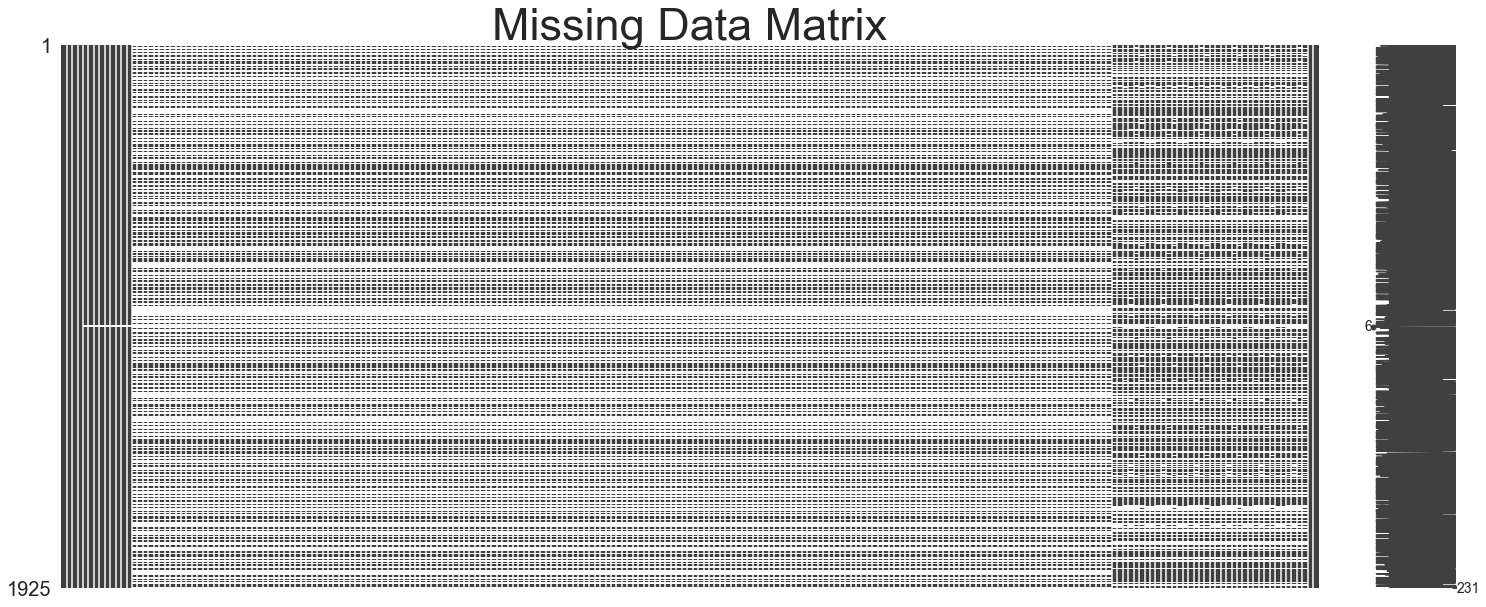

In [76]:
ax = msno.matrix(data)
ax.set_title('Missing Data Matrix', fontsize=30)

#### The graphic above illustrates how many data points are missing from the Sri Lankan COVID data. A data preparation stage was performed in order to repair it.

In [77]:
def fix_tabel(data):
    cont_features_cols = data.iloc[:,13:-2].columns
    cont_features = data.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[cont_features_cols].fillna(method='bfill').fillna(method='ffill')
    cat_features  = data.iloc[:,:13]
    output = data.iloc[:,-2:]
    data_final = pd.concat([cat_features,cont_features, output], ignore_index = True, axis=1)
    data_final.columns = data.columns
    return data_final
    

In [78]:
data_clean = fix_tabel(data)
data_clean.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,2,0
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,3,0
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,4,1


In [79]:
data_to_remove = data_clean.query('WINDOW == "0-2" and ICU ==1')['PATIENT_VISIT_IDENTIFIER'].values
data_final = data_clean.query('PATIENT_VISIT_IDENTIFIER not in @data_to_remove')
data_final = data_final.dropna()
data_final.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,191.981771,0.468750,53.307292,0.369792,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,...,-0.812388,-0.910214,-0.818008,-0.759122,-0.848720,-0.771187,-0.813295,-0.910085,2.000000,0.268229
std,111.312587,0.499152,28.625802,0.482874,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,...,0.296775,0.255728,0.301726,0.389598,0.247117,0.401430,0.295619,0.256368,1.414582,0.443153
min,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,95.750000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000
50%,191.500000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,0.000000
75%,288.250000,1.000000,80.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.690476,-0.919192,-0.710805,-0.622483,-0.764487,-0.725806,-0.698390,-0.918403,3.000000,1.000000
max,384.000000,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Feature choice

It is possible to continue selecting the data for modeling once there are no more empty values in the dataframe.When modeling a problem, one important step is selecting features.The wrong variables could result in a bad model that produces undesirable outcomes.In order to guarantee a better model, a number of different procedures will be tested in this section.

### X and y

At this section will be defined what will be the independent variables (**X**) and the dependent variable (**y**).As defined in the scope of the data presented by Sírio Libanês Hospital, the target value to be obtained is to define if a patient will be sent to ICU or not. Besides that, it is important to determine as soon as possible if the patient will demand ICU treatment.
Using this premises, it is possible to specify that the column **ICU** is the problem dependent variable. Furthermore, the column **WINDOW** will work as a kind of filter to determine the amount of information that will be used on the study.

In [80]:
# Define the initial variables
X = data_final.drop(['ICU', 'WINDOW'], axis=1)
y = data_final['ICU']

### Correlation

The feature selection by correlations is a traditional method where highly correlated parameters must not be used on modelling process. That separations is done because, from linear algebra, a system must be composed by linear independent variable.

This way, reducing the linear dependency of the variables can lead to better predictive models.

In [81]:
# checking data correlation
correl = X.corr()

correl = correl.where(np.triu(np.ones_like(correl),k=1).astype(np.bool))
correl = correl.abs()
correl

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,NaN,0.030609,0.020968,0.059944,0.076389,0.044868,0.041014,0.017013,0.009263,0.014407,...,0.030928,0.025182,0.004614,0.038469,0.016150,0.032159,0.042087,0.022280,0.005033,0.038483
AGE_ABOVE65,NaN,NaN,0.868837,0.047970,0.266971,0.067469,0.157591,0.016392,0.305052,0.015739,...,0.049166,0.136207,0.086543,0.097715,0.127839,0.137949,0.062639,0.131803,0.087487,0.098776
AGE_PERCENTIL,NaN,NaN,NaN,0.071697,0.297001,0.076109,0.131548,0.003178,0.333592,0.054903,...,0.032571,0.128009,0.084260,0.084884,0.124197,0.131590,0.040479,0.120657,0.085545,0.085933
GENDER,NaN,NaN,NaN,NaN,0.038474,0.032425,0.074494,0.054625,0.022495,0.016748,...,0.029587,0.021981,0.051045,0.027600,0.001085,0.000061,0.033932,0.020747,0.050511,0.027661
DISEASE GROUPING 1,NaN,NaN,NaN,NaN,NaN,0.194104,0.240389,0.010628,0.332670,0.168473,...,0.089166,0.072729,0.076118,0.015832,0.083740,0.091792,0.085687,0.067931,0.077617,0.015710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.830502,0.815669,0.825771,0.570788
HEART_RATE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777771,0.820578,0.541169
RESPIRATORY_RATE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.769361,0.548191
TEMPERATURE_DIFF_REL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548329


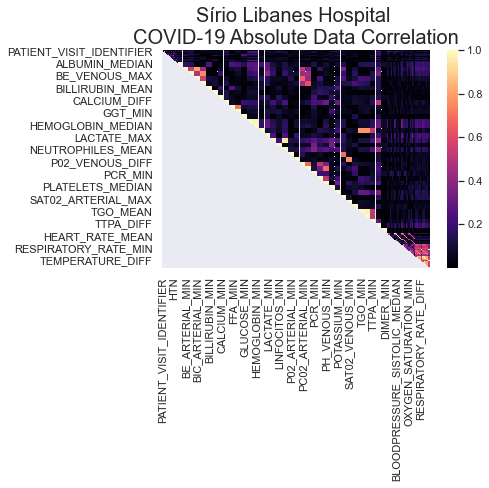

In [100]:
ax = sns.heatmap(correl, cmap='magma')
ax.set_title('''Sírio Libanes Hospital 
COVID-19 Absolute Data Correlation''',
            fontsize=20);

Once the interest in this section is to remove only highly related parameters, it was chosen to ignore values with absolute correlation above 50% to 90% percent and use these values in a future model study.

From the figure above it is possible to see that great part of the data there presented are not strongly related. So, given that, it was decided to, based on the heatmap scale, to remove values with "hotter color" correlation 

It is possible to see in the figure above that there are some data that are highly related according to the defined threshold. Given that, it is necessary to remove these highly related parameters.

In [83]:
# Removing all columns with more than 50% correlation (cf=0.5)
X_corr050 = remove_cols(X, 0.5)
print(f'Columns in X_corr050: {len(X_corr050.columns)}')

# Removing all columns with more than 60% correlation (cf=0.6)
X_corr060 = remove_cols(X, 0.6)
print(f'Columns in X_corr060: {len(X_corr060.columns)}')

# Removing all columns with more than 70% correlation (cf=0.7)
X_corr070 = remove_cols(X, 0.7)
print(f'Columns in X_corr070: {len(X_corr070.columns)}')

# Removing all columns with more than 80% correlation (cf=0.8)
X_corr080 = remove_cols(X, 0.8)
print(f'Columns in X_corr080: {len(X_corr080.columns)}')

# Removing all columns with more than 90% correlation (cf=0.9)
X_corr090 = remove_cols(X, 0.9)
print(f'Columns in X_corr090: {len(X_corr090.columns)}')

Columns in X_corr050: 74
Columns in X_corr060: 80
Columns in X_corr070: 88
Columns in X_corr080: 98
Columns in X_corr090: 104


### SelectKBest

The SelectKBest is a sklearn capability that plays out a factual test to choose the **"K"** values from the dataset.
Additionally, a study of convergence for the **K** elements will be carried out due to the large number of possibilities provided by this method.

In [84]:
X_KBest090p = SelectKBest(f_classif, k=int(X.shape[1]*0.90)).fit_transform(X, y)
print(f'Columns in X_KBest090: {X_KBest090p.shape[1]}')

X_KBest075p = SelectKBest(f_classif, k=int(X.shape[1]*0.75)).fit_transform(X, y)
print(f'Columns in X_KBest075: {X_KBest075p.shape[1]}')

X_KBest050p = SelectKBest(f_classif, k=int(X.shape[1]*0.50)).fit_transform(X, y)
print(f'Columns in X_KBest050: {X_KBest050p.shape[1]}')

X_KBest025p = SelectKBest(f_classif, k=int(X.shape[1]*0.25)).fit_transform(X, y)
print(f'Columns in X_KBest025: {X_KBest025p.shape[1]}')

Columns in X_KBest090: 206
Columns in X_KBest075: 171
Columns in X_KBest050: 114
Columns in X_KBest025: 57


### DummyClassifier

A model known as a dummy classifier represents the simplest approaches to prediction.In order to compare actual predictions, this model serves as a starting point.This way, a model must not be considered a good model if it produces a result worse than the **DummyClassifier**.

In [85]:
model_dummy = DummyClassifier()
run_modelo_cv(model_dummy, X, y, 5,10)

AUC_mean -> 0.49835435165670444

AUC -> 0.44669605278785307 | 0.5500126505255558 



0.49835435165670444

### LogisticRegression

The LogisticRegression is a linear model in Scikit Learn that allows users to use multi-class problems to perform linear regressions.
This model, in contrast to the DummyClassifier, will be used to select the best features.

In [86]:
#### Parameters setup study
## Baseline condition
model_LReg = LogisticRegression()
run_modelo_cv(model_LReg, X, y, 5,10)

AUC_mean -> 0.8904056248488409

AUC -> 0.855040327760636 | 0.9257709219370458 



0.8904056248488409

In [87]:
## max_iter
auc_iter = []
nsteps = [100,200, 400, 800, 1600, 3600, 7200]
for it in nsteps:
    print(f'Number of iterations: {it}')
    model_LReg = LogisticRegression(max_iter=it)
    auc_iter.append(run_modelo_cv(model_LReg, X, y, 5,10))

Number of iterations: 100
AUC_mean -> 0.8904056248488409

AUC -> 0.855040327760636 | 0.9257709219370458 

Number of iterations: 200
AUC_mean -> 0.8932588190581489

AUC -> 0.8594645074588265 | 0.9270531306574712 

Number of iterations: 400
AUC_mean -> 0.8931309815844937

AUC -> 0.8597330619796721 | 0.9265289011893152 

Number of iterations: 800
AUC_mean -> 0.8932705662854576

AUC -> 0.8595468461028921 | 0.9269942864680232 

Number of iterations: 1600
AUC_mean -> 0.89355249974087

AUC -> 0.8598231562361685 | 0.9272818432455716 

Number of iterations: 3600
AUC_mean -> 0.89355249974087

AUC -> 0.8598231562361685 | 0.9272818432455716 

Number of iterations: 7200
AUC_mean -> 0.89355249974087

AUC -> 0.8598231562361685 | 0.9272818432455716 



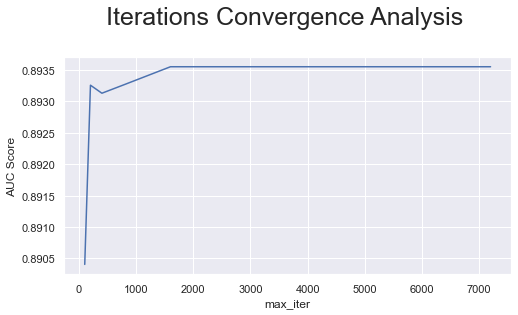

In [88]:
# Plot convergency for iterations
sns.set()
ax = sns.lineplot(x=nsteps, y=auc_iter)
ax.set_title('Iterations Convergence Analysis \n', fontsize=25)
ax.figure.set_size_inches(8,4)
ax.set(xlabel='max_iter', ylabel='AUC Score');

For the number of iterations it was possible to identify that it is necessary at least 1600 iterations to converge with the total amount of data. Besides that, it is not possible to see any significant impact on AUC score when more than 1600 iterations were used. Them, after that, it was decided that the value of max_iter used will be at least 1600 (some other parameters may request more iterations to converge).

In [89]:
## penalty
penalties = ['l2', 'none']
auc_penalty = []
for p in penalties:
    print(f'penalty = {p}')
    model_LReg = LogisticRegression(penalty=p, max_iter=10000)
    auc_penalty.append(run_modelo_cv(model_LReg, X, y, 5,10))

penalty = l2
AUC_mean -> 0.89355249974087

AUC -> 0.8598231562361685 | 0.9272818432455716 

penalty = none
AUC_mean -> 0.8876236050167572

AUC -> 0.8527149694784192 | 0.9225322405550952 



In [90]:
# dual bool [True x False]
dual = [True, False]
auc_dual = []
for d in dual:
    print(f'dual = {d}')
    model_LReg = LogisticRegression(dual=d, max_iter=1600)
    auc_dual.append(run_modelo_cv(model_LReg, X, y, 5,10))

dual = True
AUC_mean -> nan

AUC -> nan | nan 

dual = False
AUC_mean -> 0.89355249974087

AUC -> 0.8598231562361685 | 0.9272818432455716 



As observed above, there were no convergence for **dual==True**. Due to that the default value was chosen to this parameter.

In [91]:
C = np.arange(0.2,1,.1)
auc_C = []
for c in C:
    print(f'C = {c}')
    model_LReg = LogisticRegression(C=c, max_iter=1600)
    auc_C.append(run_modelo_cv(model_LReg, X, y, 5,10))

C = 0.2
AUC_mean -> 0.8931855716408115

AUC -> 0.8583331893748904 | 0.9280379539067325 

C = 0.30000000000000004
AUC_mean -> 0.8938717479183222

AUC -> 0.8595917184320679 | 0.9281517774045766 

C = 0.4000000000000001
AUC_mean -> 0.8941191307051792

AUC -> 0.8600351600852316 | 0.9282031013251268 

C = 0.5000000000000001
AUC_mean -> 0.8940887261168504

AUC -> 0.8599923335731009 | 0.9281851186605999 

C = 0.6000000000000001
AUC_mean -> 0.8939988943786062

AUC -> 0.8600219703540555 | 0.927975818403157 

C = 0.7000000000000002
AUC_mean -> 0.8938758939985487

AUC -> 0.860028984592658 | 0.9277228034044395 

C = 0.8000000000000003
AUC_mean -> 0.8937694779393982

AUC -> 0.8600030985582604 | 0.927535857320536 

C = 0.9000000000000001
AUC_mean -> 0.8936775731610405

AUC -> 0.8599728386172314 | 0.9273823077048495 



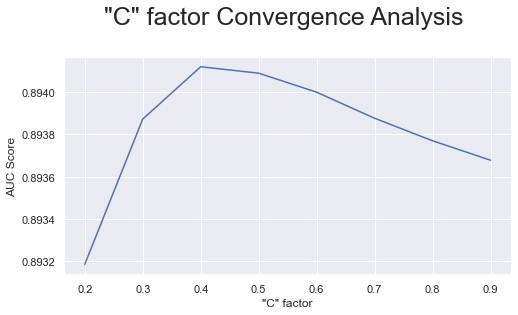

In [92]:
# Plot convergency for C fatcot
sns.set()
ax = sns.lineplot(x=C, y=auc_C)
ax.set_title('"C" factor Convergence Analysis \n', fontsize=25)
ax.figure.set_size_inches(8,4)
ax.set(xlabel='"C" factor', ylabel='AUC Score');

For **C** Factor it was possible to verify a better convergence with **C=0.5**. Even though this difference is not high compared to the standard value, it is possible to improve a little more the model.

In [93]:
# solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
auc_solver = []
for s in solver:
    print(f'solver = {s}')
    model_LReg = LogisticRegression(C=0.5, max_iter=1600, solver=s)
    auc_solver.append(run_modelo_cv(model_LReg, X, y, 5,10))

solver = newton-cg
AUC_mean -> 0.8941916871091456

AUC -> 0.860129741500315 | 0.9282536327179763 

solver = lbfgs
AUC_mean -> 0.894079742943026

AUC -> 0.8599619703128215 | 0.9281975155732304 

solver = liblinear
AUC_mean -> 0.8944038282140759

AUC -> 0.8566792379593692 | 0.9321284184687827 

solver = sag
AUC_mean -> 0.8855443457830908

AUC -> 0.8437201052304157 | 0.9273685863357659 

solver = saga
AUC_mean -> 0.8755944442524963

AUC -> 0.8311922109283753 | 0.9199966775766174 



[Text(0.5, 0, 'Solver'), Text(0, 0.5, 'AUC Score'), (0.86, 0.9)]

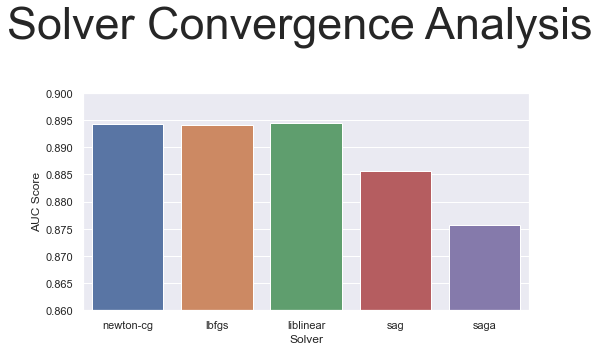

In [103]:
# Plot convergency for C fatcot
sns.set()
ax = sns.barplot(x=solver, y=auc_solver)
ax.set_title('Solver Convergence Analysis \n', fontsize=45)
ax.figure.set_size_inches(8,4)
ax.set(xlabel='Solver', ylabel='AUC Score',ylim=(0.86, 0.9))

For the solver convergence test, it was noticed that **sag** and **saga** methods didn't converged. Besides that, even though the difference between the other 3 methods were minor, it was decided to choose the one with better AUC score, the **liblinear** solver.

In [95]:
# input data correlation study
X_corr = [X_corr050, X_corr060, X_corr070, X_corr080, X_corr090, X]
X_corr_str = ['X_corr050', 'X_corr060', 'X_corr070', 'X_corr080', 'X_corr090', 'X_corr100']
auc_X_corr = []
for X, X_str in zip(X_corr,X_corr_str):
    print(f'X_corr = {X_str}')
    model_LReg = LogisticRegression(C=0.5, max_iter=1600, solver='liblinear')
    auc_X_corr.append(run_modelo_cv(model_LReg, X, y, 5,10))

X_corr = X_corr050
AUC_mean -> 0.8514297066648239

AUC -> 0.8097750039563818 | 0.8930844093732659 

X_corr = X_corr060
AUC_mean -> 0.8703710741802853

AUC -> 0.8302143606644504 | 0.9105277876961201 

X_corr = X_corr070
AUC_mean -> 0.8921739280655081

AUC -> 0.853418054032589 | 0.9309298020984272 

X_corr = X_corr080
AUC_mean -> 0.8930065991776941

AUC -> 0.8537358982604698 | 0.9322773000949184 

X_corr = X_corr090
AUC_mean -> 0.8937473655115227

AUC -> 0.8554258720533736 | 0.9320688589696717 

X_corr = X_corr100
AUC_mean -> 0.8944038282140759

AUC -> 0.8566792379593692 | 0.9321284184687827 



[Text(0.5, 0, 'INPUT Correlation'), Text(0, 0.5, 'AUC Score'), (0.85, 0.9)]

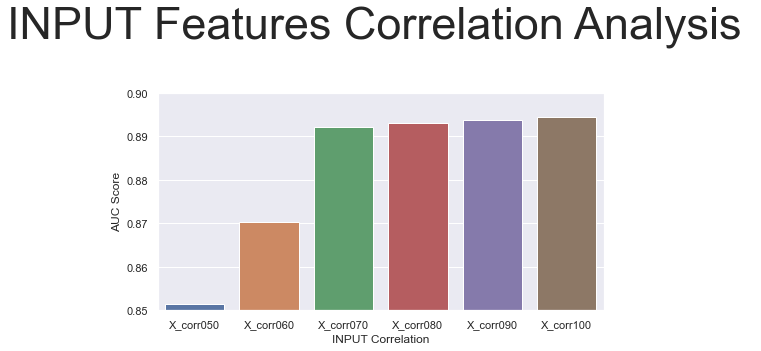

In [102]:
# Plot convergency for correlation
ax = sns.barplot(x=X_corr_str, y=auc_X_corr)
ax.set_title('INPUT Features Correlation Analysis \n', fontsize=45)
ax.figure.set_size_inches(8,4)
ax.set(xlabel='INPUT Correlation', ylabel='AUC Score',ylim=(0.85, 0.9))

With this study was possible to verify that using all input data (**X**) were obtained better data results. Given that, if this model and this method of feature selection were chosen, it must be combined with the greatest amount of data possible.

In [97]:
# input data correlation study
X_KBest = [X_KBest025p, X_KBest050p, X_KBest075p, X_KBest090p, X]
X_KBest_str = ['X_KBest025p', 'X_KBest050p', 'X_KBest075p', 'X_KBest090p', 'X_KBest100p']
auc_X_Kbest = []
for X, X_str in zip(X_KBest,X_KBest_str):
    print(f'X_KBest = {X_str}')
    model_LReg = LogisticRegression(C=0.5, max_iter=1600, solver='liblinear')
    auc_X_Kbest.append(run_modelo_cv(model_LReg, X, y, 5,10))

X_KBest = X_KBest025p
AUC_mean -> 0.8785523269875273

AUC -> 0.8406372912536393 | 0.9164673627214153 

X_KBest = X_KBest050p
AUC_mean -> 0.8848305289707354

AUC -> 0.846186483482606 | 0.9234745744588649 

X_KBest = X_KBest075p
AUC_mean -> 0.8936658259337318

AUC -> 0.8556011940930193 | 0.9317304577744443 

X_KBest = X_KBest090p
AUC_mean -> 0.8943748056524892

AUC -> 0.8566556787252233 | 0.932093932579755 

X_KBest = X_KBest100p
AUC_mean -> 0.8944038282140759

AUC -> 0.8566792379593692 | 0.9321284184687827 



[Text(0.5, 0, 'KBest Features \nThe number XXXp represents the percentage of best features'),
 Text(0, 0.5, 'AUC Score'),
 (0.87, 0.9)]

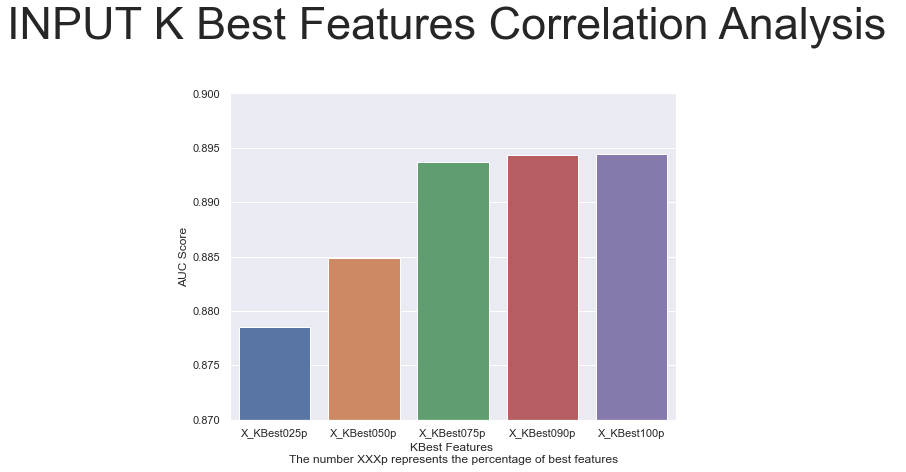

In [101]:
# Plot convergency for Kbest features
ax = sns.barplot(x=X_KBest_str, y=auc_X_Kbest)
ax.set_title('INPUT K Best Features Correlation Analysis \n', fontsize=45)
ax.figure.set_size_inches(8,6)
ax.set(xlabel='''KBest Features 
The number XXXp represents the percentage of best features''', ylabel='AUC Score',ylim=(0.87, 0.9))

The **KBest** method for choosing features returned the best AUC score until this  part of the study. Given that, it was chosen to select the **X_KBest090p** feature selection for this model.

Then, for the setup for the **LogisticRegression** model must be as presented below:

    - C -> 0.5, 
    - max_iter -> 1600, 
    - solver -> liblinear
    - Features -> KBest with 90% of the features